IMPORT LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import accuracy_score

IMPORT DATA

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kala/Sale.CSV', encoding='unicode_escape')

<ipython-input-2-03d685bd6ac4>:1: DtypeWarning: Columns (0,30,31,32,36,37,38,39,40,41,42,43,44,45,46,55,59,60,64) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kala/Sale.CSV', encoding='unicode_escape')


In [ ]:
#filtering columns
reqd_sales = data[['Invoice date','Net Unit Price','Invoice Qty','Product Group','Sales Zone']]

In [ ]:
#convert to datetime format
reqd_sales['Invoice date'] = pd.to_datetime(reqd_sales['Invoice date'],dayfirst=True)
reqd_sales['Date'] = reqd_sales['Invoice date'].dt.strftime('%Y/%m/%d')

<ipython-input-4-c10ec6a4dcd5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reqd_sales['Invoice date'] = pd.to_datetime(reqd_sales['Invoice date'],dayfirst=True)
<ipython-input-4-c10ec6a4dcd5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reqd_sales['Date'] = reqd_sales['Invoice date'].dt.strftime('%Y/%m/%d')


In [ ]:
reqd_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42818 entries, 0 to 42817
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Invoice date    42818 non-null  datetime64[ns]
 1   Net Unit Price  42818 non-null  float64       
 2   Invoice Qty     42818 non-null  int64         
 3   Product Group   42818 non-null  object        
 4   Sales Zone      42814 non-null  object        
 5   Date            42818 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 2.0+ MB


In [ ]:
#dimensionality reduction
reqd_sales['Sales'] = reqd_sales['Invoice Qty']*reqd_sales['Net Unit Price']

<ipython-input-6-5cee29db8a71>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reqd_sales['Sales'] = reqd_sales['Invoice Qty']*reqd_sales['Net Unit Price']


In [ ]:
#sort wrt date
reqd_sales = reqd_sales.sort_values(ascending=True,by='Invoice date')

In [ ]:
reqd_sales.head(10)

,Invoice date,Net Unit Price,Invoice Qty,Product Group,Sales Zone,Date,Sales
29249,2023-02-01,3652.0,2,10DA,North Zone,2023/02/01,7304.0
29224,2023-02-01,188.0,120,10TA,North Zone,2023/02/01,22560.0
29223,2023-02-01,94.0,10,10SP,North Zone,2023/02/01,940.0
29222,2023-02-01,145.0,30,10SP,North Zone,2023/02/01,4350.0
29221,2023-02-01,855.0,200,10TA,West Zone,2023/02/01,171000.0
29220,2023-02-01,7468.0,1,10ST,South Zone,2023/02/01,7468.0
29219,2023-02-01,3420.0,17,10DA,North Zone,2023/02/01,58140.0
29218,2023-02-01,4120.0,2,10DA,North Zone,2023/02/01,8240.0
29225,2023-02-01,219.0,300,10TA,North Zone,2023/02/01,65700.0
29217,2023-02-01,3708.0,3,10DL,North Zone,2023/02/01,11124.0


In [ ]:
#filtering columns
final_sales = reqd_sales[['Invoice date','Product Group','Sales']]

In [ ]:

final_sales.head(5)

,Invoice date,Product Group,Sales
29249,2023-02-01,10DA,7304.0
29224,2023-02-01,10TA,22560.0
29223,2023-02-01,10SP,940.0
29222,2023-02-01,10SP,4350.0
29221,2023-02-01,10TA,171000.0


10TA FORECASTING

In [ ]:
#taking data of 10TA product
sales_10TA = final_sales[final_sales['Product Group']=='10TA'].drop(['Product Group'],axis=1)
sales_10TA.head(5)

,Invoice date,Sales
29224,2023-02-01,22560.0
29221,2023-02-01,171000.0
29225,2023-02-01,65700.0
29228,2023-02-01,20100.0
29241,2023-02-01,92400.0


In [ ]:
#adding the sales on same date
sales_10TA = sales_10TA.groupby('Invoice date').sum()
sales_10TA.head(5)

,Sales
Invoice date,
2023-02-01,3421222.0
2023-02-02,4699037.0
2023-02-03,5258516.0
2023-02-04,5611662.0
2023-02-06,5294307.0


In [ ]:
sales_10TA_freq = sales_10TA.asfreq('d')

In [ ]:
sales_10TA_freq.isna().sum()


Sales    27
dtype: int64

In [ ]:
sales_10TA_freq.head(5)

,Sales
Invoice date,
2023-02-01,3421222.0
2023-02-02,4699037.0
2023-02-03,5258516.0
2023-02-04,5611662.0
2023-02-05,NaN


In [ ]:
sales_10TA_freq.Sales = sales_10TA_freq.Sales.fillna(method='ffill')

In [ ]:
sales_10TA_freq.isna().sum()

Sales    0
dtype: int64

<Axes: xlabel='Invoice date'>

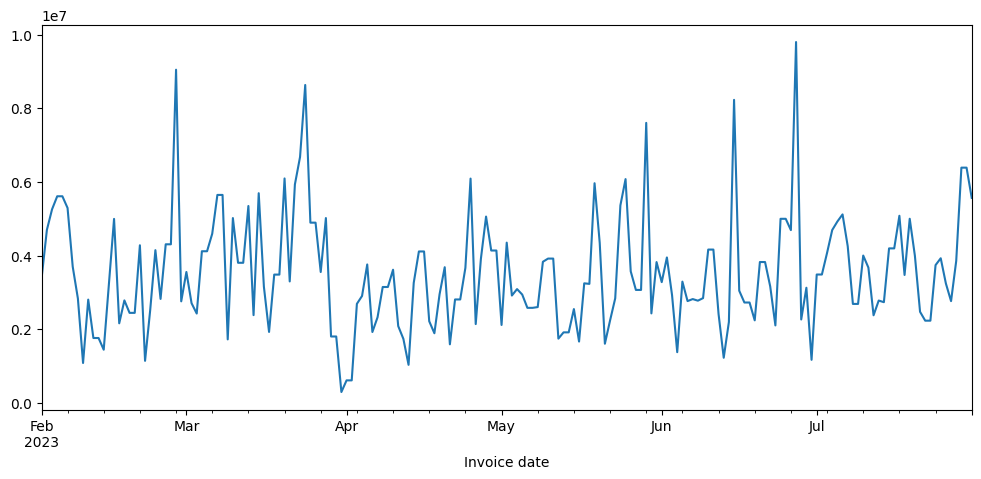

In [ ]:
#plot
sales_10TA_freq['Sales'].plot(figsize=(12,5))

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.8 MB/s eta 0:00:00


In [ ]:
#Stationary Check
def stat_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
stat_test(sales_10TA_freq['Sales'])

1. ADF :  -5.561597433781621
2. P-Value :  1.5373788430389276e-06
3. Num Of Lags :  5
4. Num Of Observations Used For ADF Regression: 175
5. Critical Values :
	 1% :  -3.4682803641749267
	 5% :  -2.8782017240816327
	 10% :  -2.5756525795918366


In [ ]:
#figure out arima model
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [ ]:
stepwise_fit = auto_arima(sales_10TA_freq['Sales'], trace=True,
suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=5666.080, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=5678.417, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=5663.137, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=5667.664, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6005.426, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=5663.086, Time=0.09 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=5663.556, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=5664.689, Time=0.21 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=5664.549, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=5665.552, Time=0.34 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=5703.340, Time=0.11 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 1.851 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  181
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -2827.543
Date:                Sat, 14 Oct 2023   AIC                           5663.086
Time:                        15:05:01   BIC                           5675.880
Sample:                    02-01-2023   HQIC                          5668.273
                         - 07-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.185e+06    3.3e+05      6.623      0.000    1.54e+06    2.83e+06
ar.L1          0.2733      0.068      4.041      0.000       0.141       0.406
ar.L2          0.1088      0.086      1.263      0.207      -0.060       0.278
sigma2      2.185e+12      0.124   1.77e+13      0.000    2.18e+12    2.18e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                57.92
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.94
Prob(H) (two-sided):                  0.55   Kurtosis:                         5.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.14e+28. Standard errors may be unstable.
"""

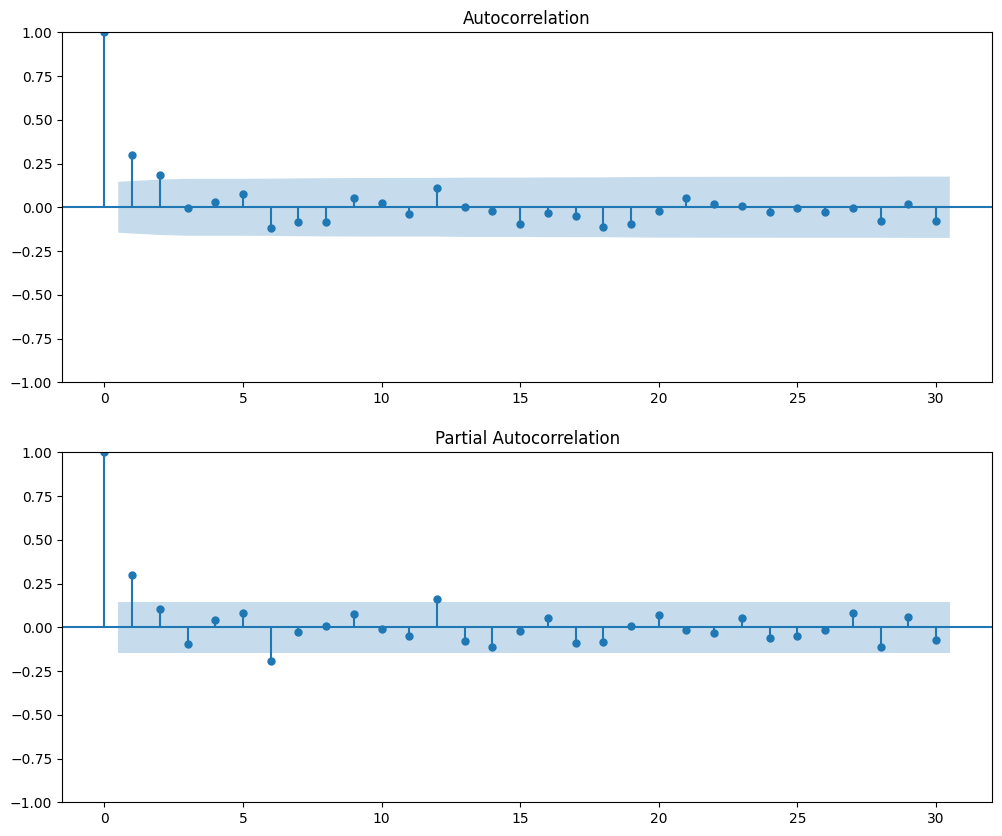

In [ ]:
#acf and pacf plots
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sales_10TA_freq['Sales'],lags = 30,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sales_10TA_freq['Sales'],lags = 30,ax=ax2)

In [ ]:
#Split to train and test
print(sales_10TA_freq.shape)
train=sales_10TA_freq.iloc[:-20]
test=sales_10TA_freq.iloc[-20:]
print(train.shape,test.shape)

(181, 1)
(161, 1) (20, 1)


In [ ]:
#Train The model
model = sm.tsa.arima.ARIMA(train['Sales'],order=(1,0,30))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  161
Model:                ARIMA(1, 0, 30)   Log Likelihood               -2499.660
Date:                Sat, 14 Oct 2023   AIC                           5065.321
Time:                        15:09:29   BIC                           5167.007
Sample:                    02-01-2023   HQIC                          5106.609
                         - 07-11-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.491e+06    9.8e+04     35.612      0.000     3.3e+06    3.68e+06
ar.L1          0.4077      5.757      0.071      0.944     -10.876      11.692
ma.L1         -0.0972      5.781     -0.017      0.987     -11.429      11.234
ma.L2          0.1887      1.779      0.106      0.916      -3.299       3.676
ma.L3         -0.1272      1.798     -0.071      0.944      -3.651       3.396
ma.L4         -0.0393      0.472     -0.083      0.934      -0.965       0.886
ma.L5          0.1623      0.369      0.439      0.660      -0.562       0.886
ma.L6         -0.1219      0.829     -0.147      0.883      -1.746       1.503
ma.L7         -0.0446      0.456     -0.098      0.922      -0.938       0.849
ma.L8         -0.1800      0.468     -0.384      0.701      -1.098       0.738
ma.L9          0.1401      1.186      0.118      0.906      -2.184       2.464
ma.L10         0.0573      0.342      0.168      0.867      -0.612       0.727
ma.L11        -0.1770      0.484     -0.366      0.715      -1.126       0.772
ma.L12         0.0826      0.838      0.099      0.922      -1.561       1.726
ma.L13        -0.0355      0.188     -0.188      0.851      -0.405       0.334
ma.L14        -0.0051      0.335     -0.015      0.988      -0.661       0.651
ma.L15        -0.0748      0.280     -0.268      0.789      -0.623       0.473
ma.L16        -0.0038      0.489     -0.008      0.994      -0.962       0.954
ma.L17        -0.0562      0.338     -0.167      0.868      -0.718       0.605
ma.L18        -0.0637      0.424     -0.150      0.880      -0.895       0.767
ma.L19        -0.2090      0.575     -0.364      0.716      -1.335       0.917
ma.L20        -0.0295      1.435     -0.021      0.984      -2.841       2.782
ma.L21         0.1935      0.706      0.274      0.784      -1.191       1.578
ma.L22         0.0536      0.811      0.066      0.947      -1.537       1.644
ma.L23         0.0571      0.718      0.079      0.937      -1.351       1.465
ma.L24        -0.1379      0.589     -0.234      0.815      -1.293       1.017
ma.L25        -0.1079      0.633     -0.171      0.865      -1.348       1.132
ma.L26        -0.0401      0.853     -0.047      0.962      -1.712       1.631
ma.L27        -0.0835      0.604     -0.138      0.890      -1.267       1.100
ma.L28        -0.1565      0.741     -0.211      0.833      -1.609       1.296
ma.L29         0.2426      1.197      0.203      0.839      -2.102       2.588
ma.L30        -0.0832      0.918     -0.091      0.928      -1.882       1.716
sigma2      1.549e+12    2.4e-08   6.44e+19      0.000    1.55e+12    1.55e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                20.30
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                             0.70
Prob(H) (two-sided):                  0.93   Kurtosis:       

In [ ]:
#prediction
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.index = sales_10TA_freq.index[start:end+1]
print(pred)

Invoice date
2023-07-12    3.579338e+06
2023-07-13    2.480183e+06
2023-07-14    3.775304e+06
2023-07-15    3.649207e+06
2023-07-16    2.926559e+06
2023-07-17    4.471342e+06
2023-07-18    4.557153e+06
2023-07-19    3.811053e+06
2023-07-20    3.074516e+06
2023-07-21    2.168054e+06
2023-07-22    1.790075e+06
2023-07-23    3.170338e+06
2023-07-24    3.508073e+06
2023-07-25    3.619011e+06
2023-07-26    5.344103e+06
2023-07-27    3.505574e+06
2023-07-28    3.269760e+06
2023-07-29    2.582189e+06
2023-07-30    2.941693e+06
2023-07-31    3.167292e+06
Freq: D, Name: ARIMA Predictions, dtype: float64


<Axes: xlabel='Invoice date'>

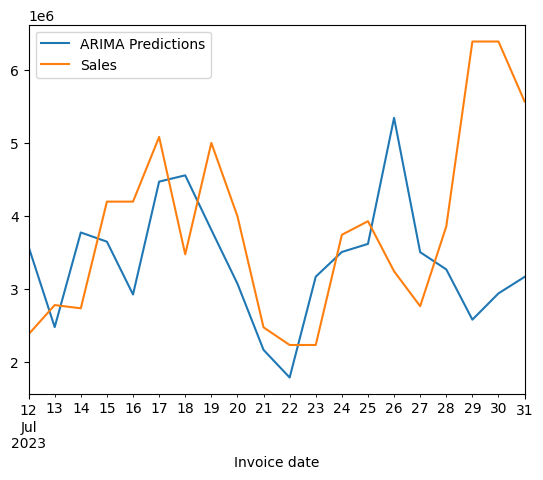

In [ ]:
#plot
pred.plot(legend=True)
test['Sales'].plot(legend=True)

In [ ]:
print(test)

                   Sales
Invoice date            
2023-07-12    2381782.41
2023-07-13    2781594.26
2023-07-14    2737234.45
2023-07-15    4197298.96
2023-07-16    4197298.96
2023-07-17    5082459.22
2023-07-18    3475855.01
2023-07-19    5001479.21
2023-07-20    3997690.26
2023-07-21    2476478.62
2023-07-22    2235373.38
2023-07-23    2235373.38
2023-07-24    3743358.13
2023-07-25    3929414.97
2023-07-26    3244134.07
2023-07-27    2766060.57
2023-07-28    3858044.29
2023-07-29    6388544.11
2023-07-30    6388544.11
2023-07-31    5567268.59


In [ ]:
model_ar1 = sm.tsa.arima.ARIMA(train['Sales'],order=(1,0,0))
result_ar1 = model_ar1.fit()
result_ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  161
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2520.160
Date:                Tue, 17 Oct 2023   AIC                           5046.321
Time:                        14:23:57   BIC                           5055.565
Sample:                    02-01-2023   HQIC                          5050.074
                         - 07-11-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.491e+06   1.73e+05     20.165      0.000    3.15e+06    3.83e+06
ar.L1          0.2751      0.065      4.226      0.000       0.148       0.403
sigma2      2.324e+12      0.080   2.89e+13      0.000    2.32e+12    2.32e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                56.23
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                             1.00
Prob(H) (two-sided):                  0.92   Kurtosis:                         5.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.46e+28. Standard errors may be unstable.
"""

In [ ]:
model_ar2 = sm.tsa.arima.ARIMA(train['Sales'],order=(2,0,0))
result_ar2 = model_ar2.fit()
result_ar2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  161
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -2519.038
Date:                Tue, 17 Oct 2023   AIC                           5046.075
Time:                        14:24:26   BIC                           5058.401
Sample:                    02-01-2023   HQIC                          5051.080
                         - 07-11-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.491e+06   1.94e+05     17.968      0.000    3.11e+06    3.87e+06
ar.L1          0.2424      0.075      3.232      0.001       0.095       0.389
ar.L2          0.1173      0.092      1.272      0.203      -0.063       0.298
sigma2      2.296e+12      0.105    2.2e+13      0.000     2.3e+12     2.3e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                57.03
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             1.02
Prob(H) (two-sided):                  0.70   Kurtosis:                         5.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.18e+28. Standard errors may be unstable.
"""